In [2]:
from math import sqrt
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import random

In [6]:
main = pd.read_csv(r"./data/_descriptors.csv", index_col=0)
print(len(main.columns))
main.head()

2149


,name,container,cas,mw,solute-smiles,solvent-smiles,solvent-name,dm300,dm300-error,ABC_caller,...,SRW10_other,TSRW10_other,MW_other,AMW_other,WPath_other,WPol_other,Zagreb1_other,Zagreb2_other,mZagreb1,mZagreb2_other
0,"3,5-Diaminobenzoic Acid",Z1,535-87-5,152.15,O=C(O)C1=CC(N)=CC(N)=C1,CO,Methanol,0.6452,0.0230,8.175294,...,1.098612,7.493061,32.026215,5.337702,1.0,0.0,2.0,1.0,2.0,1.0
1,4-Aminobenzoic acid,D2,150-13-0,137.00,Nc1ccc(cc1)C(O)=O,CO,Methanol,0.8522,0.0147,7.358797,...,1.098612,7.493061,32.026215,5.337702,1.0,0.0,2.0,1.0,2.0,1.0
2,"4,6-diaminoresorcinol dihydrochloride",RA15,16523-31-2,212.01,OC1=C(N)C=C(N)C(O)=C1,CO,Methanol,0.3576,0.0775,7.427747,...,1.098612,7.493061,32.026215,5.337702,1.0,0.0,2.0,1.0,2.0,1.0
3,Cytosine,AP17,71-30-7,111.00,C1=C(NC(=O)N=C1)N,CO,Methanol,0.6643,0.0225,5.875634,...,1.098612,7.493061,32.026215,5.337702,1.0,0.0,2.0,1.0,2.0,1.0
4,"4-AMINOPYRIDINE, 98%",D6,504-24-5,94.00,Nc1ccncc1,CO,Methanol,0.1865,0.0425,5.059137,...,1.098612,7.493061,32.026215,5.337702,1.0,0.0,2.0,1.0,2.0,1.0


In [34]:
def insert_inf(ndarray): # this function is hardcoded but it works for now
    for i in range(12):
        ndarray = np.insert(ndarray, 0, 99999-10+i) # but what the heck is this line? Old Gergo, what an absolute shitty code, my eyes hurts :(
    return ndarray

def insert_row(df, df_insert, idx=-1):
    dfA = df.iloc[:idx, ]
    dfB = df.iloc[idx:, ]
    df = dfA.append(df_insert).append(dfB).reset_index(drop = True)
    return df

def data_plot(data, p):
    p.map(plt.scatter, 'o2', 'y_pred', color = 'red')
    p.map(sns.regplot, 'o2', 'y_pred', scatter = False, ci = 95, 
        fit_reg = True, color = 'blue') 
    p.map(sns.regplot, 'o2', 'y_pred', scatter = False, ci = 0, 
        fit_reg = True, color = 'darkgreen')

def capping(y_pred):
    for enum, k in enumerate(y_pred):
        if k > 1:
            y_pred[enum] = 1
    return y_pred

def removal(dataframe, rate):
    df = dataframe.iloc[rate:]
    return df

def genetic(X, y, data, rate=6, n_components=5):
    model = PLSRegression(n_components=n_components)
    model.fit(X, y)
    #y_pred = capping(model.predict(X))
    y_pred = model.predict(X)
    y_cv = cross_val_predict(model, X, y, cv=5)
    data['y_pred'] = y_pred
    data['y_cv'] = y_cv
    data['diff'] = np.array([abs((y_pred[i]-y[i])/y[i]).tolist() for i in range(len(y_cv))])
    # generate list of random number:
    droput = random.sample(range(4, len(data.columns)), rate)
    data = data.drop(data.columns[droput], axis=1, inplace=True)


def variable_selection(X, y, data, i, rate=4, n_components=5):
    """
    Performs variable selection
    """
    model = PLSRegression(n_components=n_components)
    model.fit(X, y)
    #y_pred = capping(model.predict(X))
    y_pred = model.predict(X)
    y_cv = cross_val_predict(model, X, y, cv=5)
    data['y_pred'] = y_pred
    data['y_cv'] = y_cv
    data['diff'] = np.array([abs(( y[i] - y_pred[i] ) / y[i] ).tolist() for i in range(len(y_cv))])
    # extracting variable importance
    importance = np.abs(model.coef_)
    ins_importance = insert_inf(importance)
    importance = pd.DataFrame(ins_importance.reshape(1,len(data.columns)), columns=data.columns)
    data = pd.concat([data, importance],ignore_index=True)
    data = data.sort_values(data.last_valid_index(), axis=1, ascending=False)
    data = data.iloc[:-1, :len(data.columns)-rate]
    # Evaluation
    r2_cv = r2_score(y, y_cv)
    rmse_cv = sqrt(mean_squared_error(y, y_cv))
    r2_train = r2_score(y, y_pred)
    rmse_train = sqrt(mean_squared_error(y, y_pred))
    importance = model.coef_
    # Plotting
    # plt.figure()
    # sns.set(rc={'figure.figsize':(11.7,8.27), 'axes.facecolor':'white', 'figure.facecolor':'white'})
    # regplot = sns.regplot(y, y_pred, ci=None, scatter_kws={"color": "#00204c"}, line_kws={"color": "#dfcb5d"})
    # regplot.set(ylim=(0, 1), xlim=(0, 1))
    # plt.text(0,0.1, f'Generation number: {i}\nRMSE train: {round(rmse_train*100, 2)}\nRMSE cross-validation: {round(rmse_cv*100, 2)}')
    # fig = regplot.get_figure()
    # fig.savefig(f'training_gif/{i}.png')
    return (data, r2_cv, rmse_cv, r2_train, rmse_train, importance)


def denoise(X, y, data, i,rate, n_components=5):
    """
    Removes the outliers
    """
    model = PLSRegression(n_components=n_components)
    model.fit(X, y)
    #y_pred = capping(model.predict(X)) 
    y_pred = model.predict(X)
    y_cv = cross_val_predict(model, X, y, cv=5)
    data['y_pred'] = y_pred
    data['y_cv'] = y_cv
    data['diff'] = np.array([abs(( y[i] - y_pred[i] ) / y[i] ).tolist() for i in range(len(y_cv))])
    data = data.sort_values(by=['diff'], ascending=False)
    data = removal(data, rate)
    # Evaluation
    r2_cv = r2_score(y, y_cv)
    rmse_cv = sqrt(mean_squared_error(y, y_cv))
    r2_train = r2_score(y, y_pred)
    rmse_train = sqrt(mean_squared_error(y, y_pred))
    importance = model.coef_
    # Plotting 
    # plt.figure()
    # sns.set(rc={'figure.figsize':(11.7,8.27), 'axes.facecolor':'white', 'figure.facecolor':'white'})
    # regplot = sns.regplot(y, y_pred, ci=None, scatter_kws={"color": "#00204c"}, line_kws={"color": "#dfcb5d"})
    # regplot.set(ylim=(0, 1), xlim=(0, 1))
    # plt.text(0,0.1, f'Generation number: {i}\nRMSE train: {round(rmse_train*100, 2)}\nRMSE cross-validation: {round(rmse_cv*100, 2)}')
    # fig = regplot.get_figure()
    # fig.savefig(f'training_gif/{i}.png')
    return (data, r2_cv, rmse_cv, r2_train, rmse_train, importance)

In [37]:
def fn(generation, mempar):
    data = pd.read_csv(r'./data/_descriptors.csv', index_col=0)
    data[mempar] = np.divide(data[mempar], max(data[mempar]))
    data.insert(loc=0, column='y_pred', value=np.array(range(len(data))))
    data.insert(loc=0, column='y_cv', value=np.array(range(len(data))))
    data.insert(loc=0, column='diff', value=np.array(range(len(data))))

    mempar = mempar
    #plot = sns.FacetGrid(data, size = 4, aspect = 1.5)

    r2_cv_lst = []
    rmse_cv_lst = []
    r2_train_lst = []
    rmse_train_lst = []
    for i in range(generation):
        if i % 2 == 0 and i < 1000:
            y = data[mempar].to_numpy().astype('float64')
            X = data.iloc[:,12:].to_numpy().astype('float64')
            data, r2_cv, rmse_cv, r2_train, rmse_train, importance = denoise(X, y, data, i, rate=10)

        y = data[mempar].to_numpy().astype('float64')
        X = data.iloc[:,12:].to_numpy().astype('float64')
        data, r2_cv, rmse_cv, r2_train, rmse_train, importance = variable_selection(X, y, data, i,rate=10)

        r2_cv_lst.append(r2_cv)
        rmse_cv_lst.append(rmse_cv)
        r2_train_lst.append(r2_train)
        rmse_train_lst.append(rmse_train)

        print("Generation:", i, 
            "| CV R2:", round(r2_cv*100, 3), 
            "| CV RMSE:", round(rmse_cv*100, 3), 
            "| Train R2:", round(r2_train*100, 3), 
            "| Train RMSE:", round(rmse_train*100, 3))

    #data.to_csv(mempar + '_gen_' + str(generation) + '.csv', sep=',')
    return (r2_cv_lst, rmse_cv_lst, r2_train_lst, rmse_train_lst, importance, data)

# for generation in [1200]:
#     for mempar in ['150-20']:        
r2_cv_lst, rmse_cv_lst, r2_train_lst, rmse_train_lst, importance, data = fn(generation=2, mempar="dm300")

Generation: 0 | CV R2: 66.655 | CV RMSE: 19.439 | Train R2: 74.559 | Train RMSE: 16.979
Generation: 1 | CV R2: 66.655 | CV RMSE: 19.439 | Train R2: 74.559 | Train RMSE: 16.979


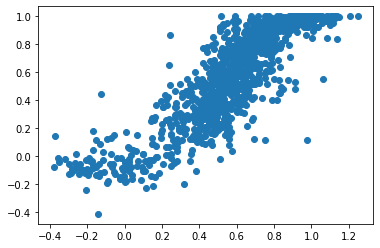

In [38]:
plt.scatter(data['y_pred'], data['dm300'])
# plt.xlim(0,20)
# plt.ylim(0,20)

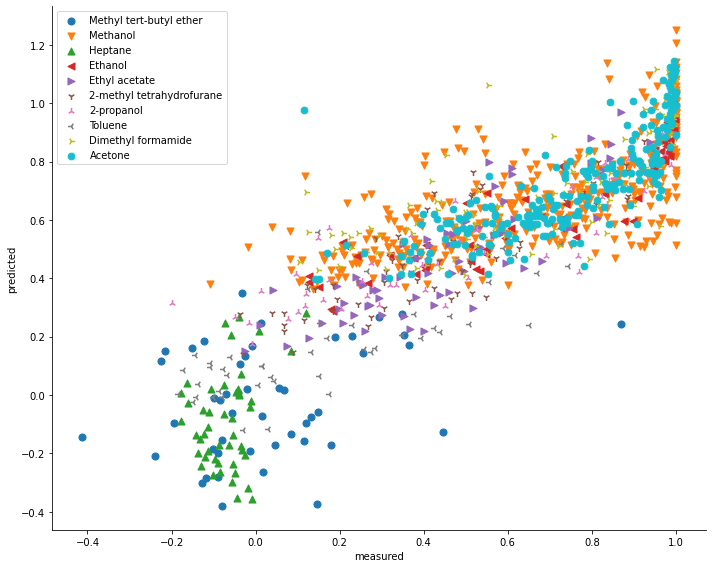

In [39]:
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score
import matplotlib.colors as colors
import matplotlib.cm as cmx

def rejection_diagram(x: str, y: str, data: pd.DataFrame, x_axis: str, y_axis: str, group="solvent-name"):
    """
    :x: measured data
    :y: predicted data
    :data: pandas dataframe
    :x_axis: Label name on the X-axis
    :y_axis: Label name on the Y-axis
    """
    plt.figure(figsize=(10,8), tight_layout=True)
    ax = plt.axes()
    ax.set(facecolor = "white")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    _data = data.dropna(subset=[x])
    x_values=_data[x]
    y_values=_data[y]
    
    # Get unique names of species
    uniq = list(set(_data[group]))

    # Set the color map to match the number of species
    z = range(1,len(uniq))
    hot = plt.get_cmap('tab20')
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    markers = ["o", "v", "^", "<", ">", "1", "2",
                "3", "4", "8", "s", "p", "P", "*",
                "h", "H", "+", "x", "X", "D", "d"]

    for enum, (k, i) in enumerate(zip(uniq, markers)):
        indx = _data[group] == k
        plt.scatter(x_values[indx], y_values[indx], s=50, color=scalarMap.to_rgba(enum), label=k, marker=i)

    plt.legend()#loc='lower right', bbox_to_anchor=(2, 0))
    # plt.ylim(-1,3)

    # z = np.polyfit(_data[x], _data[y], 1)
    # p = np.poly1d(z)
    # y_hat = np.poly1d(z)(_data[x])

    # r_square = r2_score(_data[y], y_hat)
    # plt.plot(_data[x],p(_data[x]),"-")
    
    
    # text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(_data[y],y_hat):0.3f}$"
    # plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
    #     fontsize=10, verticalalignment='top')

    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    

    # print('equation parameters: ', z)
    # print('r2 score', r_square)
    # return np.array(_data['polymer_type'].map(colors))[0]


plot = rejection_diagram(data=data, x='dm300', y='y_pred', x_axis='measured', y_axis='predicted', group='solvent-name')

In [4]:
df = pd.read_csv("/Users/ignaczg/Dropbox/Gergo Ignacz/Projects/AI/prediction-article/auxiliary files/development/150-20_gen_1131.csv")
y = df['150-20']
X = df.iloc[:,79:]
model = PLSRegression(n_components=5)
model.fit(X,y)
import joblib
joblib.dump(model, 'pls_model.sav') 

['pls_model.sav']

In [ ]:
df.columns[79:].to_numpy()

In [ ]:
print(X.iloc[:,:].to_numpy())

In [57]:
loaded_model = joblib.load("pls_model.sav")
predict = loaded_model.predict(X.iloc[0,:].to_numpy().reshape(1,-1))
predict

array([[0.72477412]])

In [8]:
def eval(generation, mempar):
    df = pd.read_csv('/Users/ignaczg/Dropbox/Gergo Ignacz/Projects/AI/prediction-article/auxiliary files/development/150-20_gen_1242.csv')
    r2_cv = r2_score(df[mempar], df['y_cv'])
    rmse_cv = sqrt(mean_squared_error(df[mempar], df['y_cv']))
    r2_train = r2_score(df[mempar], df['y_pred'])
    rmse_train = sqrt(mean_squared_error(df[mempar], df['y_pred']))

    return (r2_cv, rmse_cv, r2_train, rmse_train)

r2_cv, rmse_cv, r2_train, rmse_train = eval(1242, '150-20')

# for mempar in ['150-20','200-20', '300-20', '150-10', '200-10', '300-10']:
#     for generation in [1131]:
#         print(f'Generation: {generation}', f'Membrane: {mempar}', eval(generation, mempar))

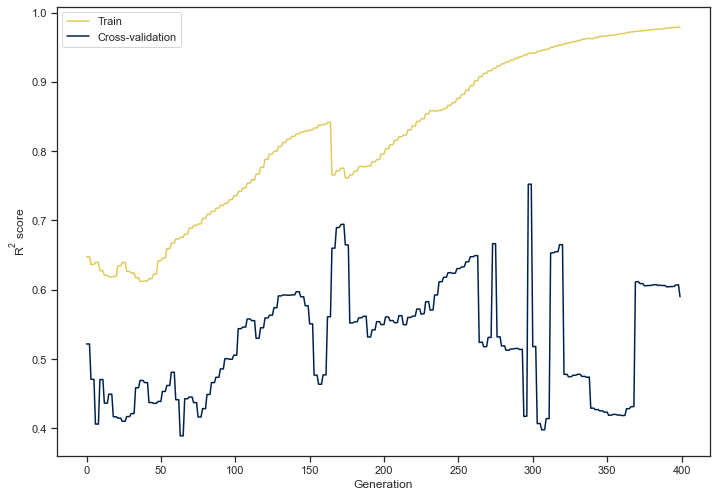

In [75]:
# RMSE and CV plotting with generation
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("ticks")
ax1 = sns.lineplot(range(len(r2_train_lst)), (r2_train_lst), color='#dfcb5d')
ax1 = sns.lineplot(range(len(r2_cv_lst)), (r2_cv_lst), color='#00204c')
ax1.set_ylabel('$\mathregular{R^{2}}$ score')
ax1.set_xlabel('Generation')
ax1.set_title('')
plt.legend(['Train', 'Cross-validation'])
plt.savefig('figure-2-r2-cv.png')

In [33]:
for enum in range(1131):
    plt.figure()
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_style("ticks")
    #fig, axs = plt.subplots(nrows=2, ncols=1)
    ax1 = sns.lineplot(range(len(rmse_train_lst[0:enum])), (rmse_train_lst[0:enum]), color='#dfcb5d')
    ax1 = sns.lineplot(range(len(rmse_cv_lst[0:enum])), (rmse_cv_lst[0:enum]), color='#00204c')
    ax1.set(ylim=(0.065, 0.16), xlim=(0, 1200))
    plt.text(0,0.1, f'Generation number: {enum}\nRMSE train: {round(rmse_train_lst[enum]*100, 2)}\nRMSE cross-validation: {round(rmse_cv_lst[enum]*100, 2)}')
    ax1.set_ylabel('RMSE score')
    ax1.set_xlabel('Generation')
    ax1.set_title('')
    plt.legend(['Train', 'Cross-validation'])
    plt.savefig(f'training_gif_2/{enum}.png')

Text(0.5, 1.0, '')

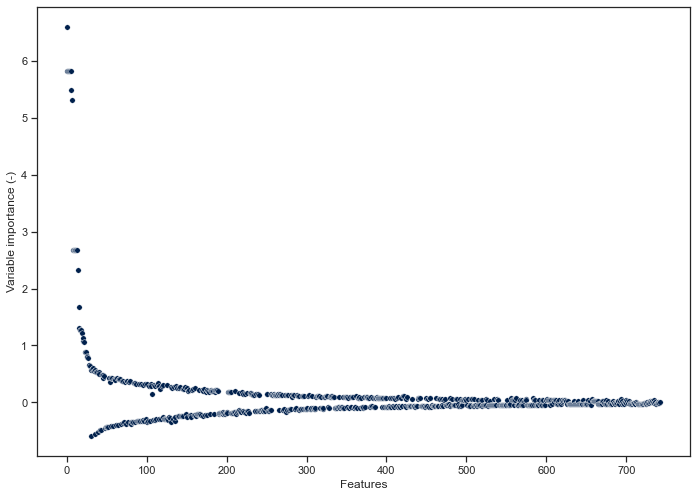

In [76]:
# Variable importance projection plotting
#sns.set(rc={'figure.figsize':(8,5)})
#sns.set_style("ticks")
plt.tight_layout()
ax1 = sns.scatterplot(y=importance.reshape(-1), x=range(len(importance)), s=30, color='#00204c')
ax1.set_ylabel('Variable importance (-)')
ax1.set_xlabel('Features')
ax1.set_title('')
# plt.savefig('figure-2-variable-importance-plot.svg')


In [91]:
from PIL import ImageColor
colors = pd.read_csv('colorlist.csv').to_numpy()
rgbs = np.divide([ImageColor.getcolor(hex[0], "RGB") for hex in colors], 255)

features = pd.read_csv('prediction_files/150-20_gen_1131.csv')
columns = features.columns
# len(columns[79:])
# len(importance[:108])
# vip = dict(zip(columns[79:], importance[].astype('float64')))



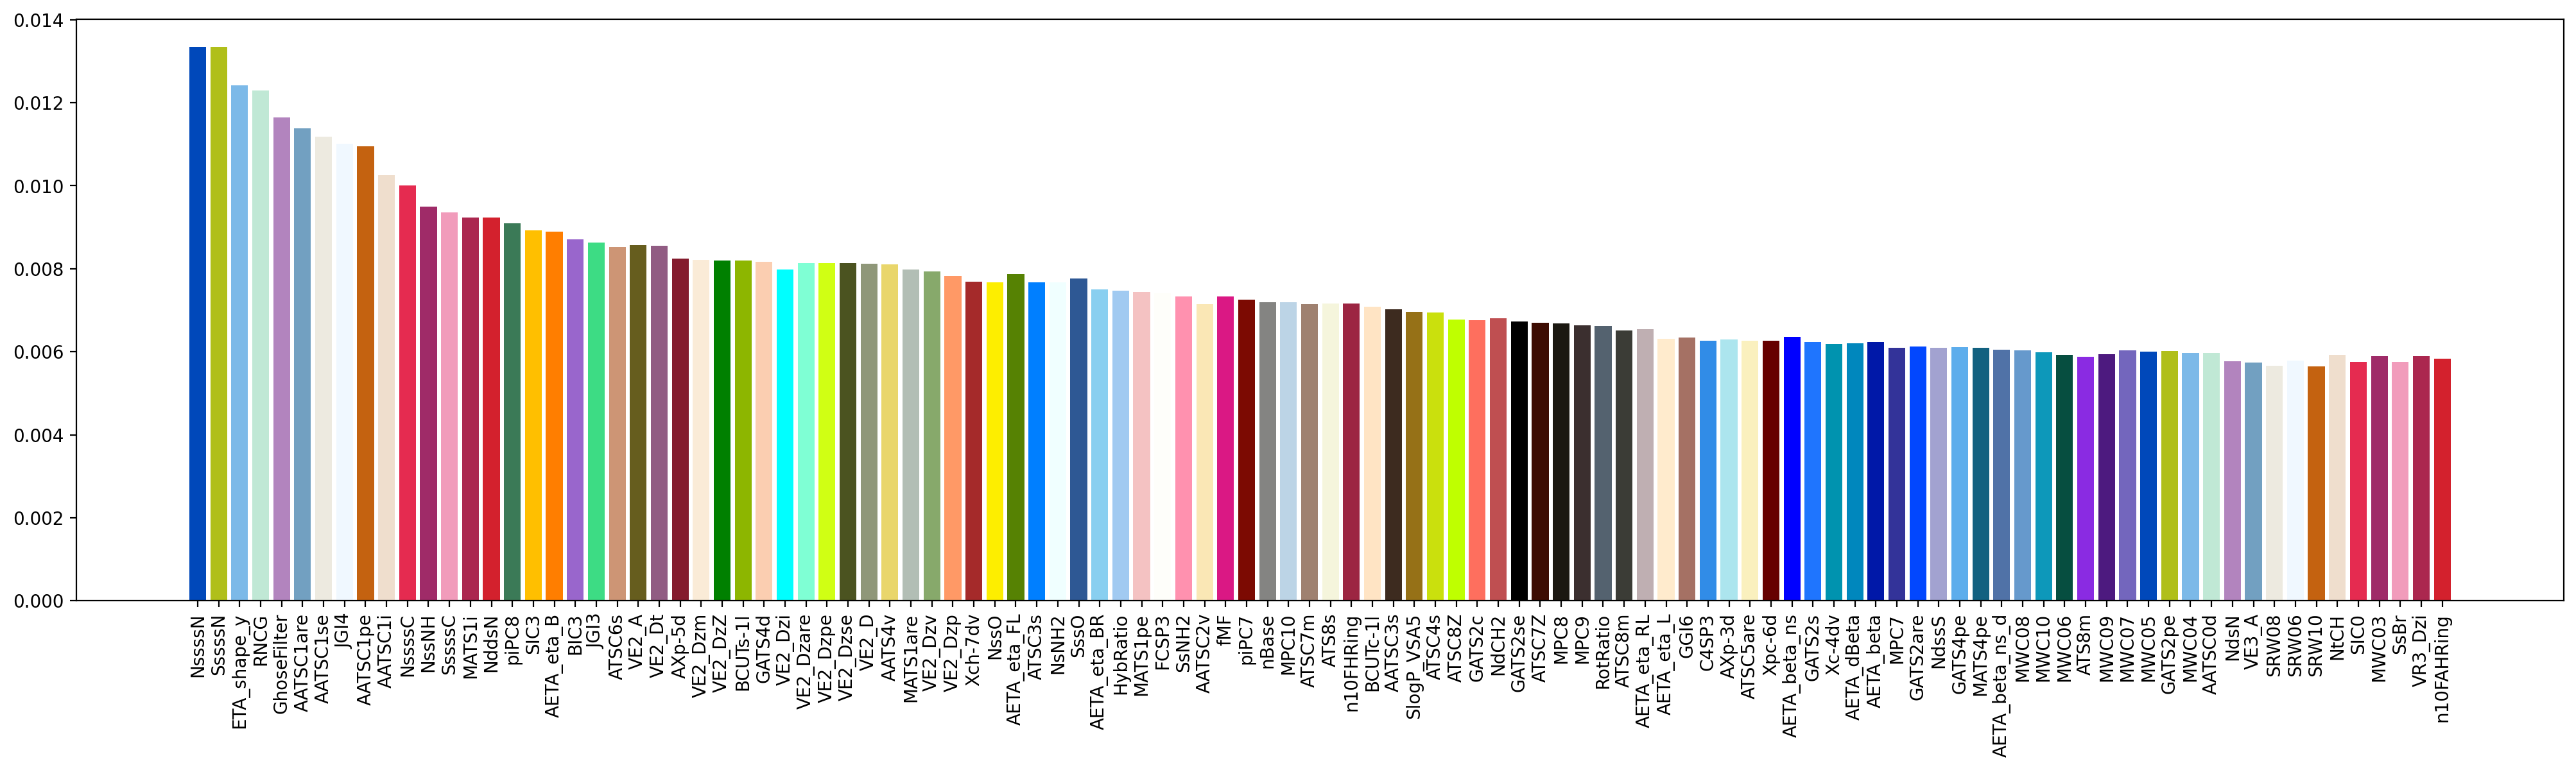

In [118]:
plt.figure(figsize=(25, 6), dpi=200)
ax = plt.bar(columns[79:], np.abs(importance[:108].reshape(-1)), color=rgbs)
plt.xticks(rotation=90)
# plt.bar_label(ax, fmt='%.3f', rotate=90)
plt.show()

In [115]:
a = dict(zip(columns[79:], importance[:108].reshape(-1)))
df = pd.DataFrame.from_dict(a, orient='index')
df.to_csv('importance.csv')


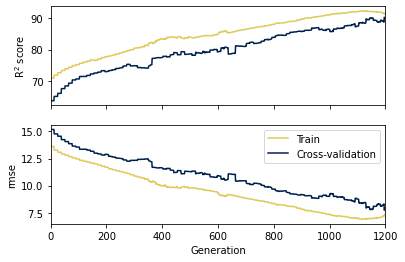

In [9]:
fig, axs = plt.subplots(2, sharex=True)
#fig.tight_layout()
axs[0].plot(range(generation), (np.multiply(100,r2_train_lst)), color='#dfcb5d')
axs[0].plot(range(generation), (np.multiply(100, r2_cv_lst)), color='#00204c')
axs[0].set_ylabel('$\mathregular{R^{2}}$ score')
axs[0].set_xlabel('')
axs[0].set_xlim(0,1200)

axs[1].plot(range(generation), (np.multiply(100,rmse_train_lst)), color='#dfcb5d')
axs[1].plot(range(generation), (np.multiply(100,rmse_cv_lst)), color='#00204c')
axs[1].set_ylabel('rmse')
axs[1].set_xlabel('Generation')
plt.legend(['Train', 'Cross-validation'])
plt.savefig('figure-2-rmse-r2-score.svg')


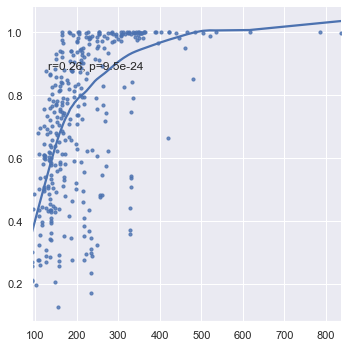

In [10]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.lmplot(x="Mw", y="150-20", data=data,
           lowess=True, ci=None, scatter_kws={"s": 10})

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Mw'], data['150-20'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r**2, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()
g.savefig('figure-1b.svg')

In [5]:
data = pd.read_csv('master_descriptors.csv', index_col=0)
data.insert(loc=0, column='y_pred', value=np.array(range(len(data))))
data.insert(loc=0, column='y_cv', value=np.array(range(len(data))))
data.insert(loc=0, column='diff', value=np.array(range(len(data))))
y = data['150-20'].to_numpy().astype('float64')
X = data.iloc[:,78:len(data.columns)].to_numpy().astype('float64')
data = genetic(X, y, data)

In [72]:
def train_pls(X, y, n_components=10):
    rmse_train = []
    rmse_cross = []
    r2_train = []
    r2_cross = []
    for i in range(1,n_components-1):
        model = PLSRegression(n_components=i)
        model.fit(X, y)
        y_pred = model.predict(X)
        y_cv = cross_val_predict(model, X, y, cv=20)
        for enum, k in enumerate(y_pred):
            if k > 1:
                y_pred[enum] = k
        rmse_cross.append(mean_squared_error(y, y_cv))
        rmse_train.append(mean_squared_error(y, y_pred))
        r2_train.append(r2_score(y, y_pred))
        r2_cross.append(r2_score(y, y_cv))
        print(f"N components: {i}")
        print(f"RMSE Train-Cross: {abs(mean_squared_error(y, y_pred)-mean_squared_error(y, y_cv))}")
        print(f"R2 cross: {r2_score(y, y_cv)}")

    plt.plot(range(n_components-2), rmse_cross)
    plt.plot(range(n_components-2), rmse_train)
    plt.plot(range(n_components-2), [abs(rmse_train[i]-rmse_cross[i]) for i in range(len(rmse_cross))])
    plt.xlim(0,n_components)
    #plt.tick_params


328

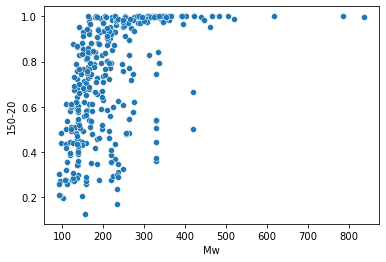

In [30]:
df_ = pd.read_csv('/Users/ignaczg/Dropbox/Gergo Ignacz/Projects/AI/prediction-article/development/prediction_files/150-20_gen_1131.csv')
sns.scatterplot(y=df_['150-20'], x=df_['Mw'])
len(df_)